Look at sample lifetimes and under stand some numbers that we might expect if everything works 'well'.

In [127]:
import sys, os
sys.path.append(os.pardir)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from hep_tables import xaod_table, make_local
from func_adl import EventDataset

from data import get_ds

In [6]:
ds = get_ds(mH=125, mS=35, lifetime=5, campaign='mc16e')
assert len(ds) == 1
ds

,mH,mS,Lifetime,MCCampaign,RucioDSName,Use,Comments
18,125,35,5,mc16e,mc16_13TeV.311312.MadGraphPythia8EvtGen_A14NNP...,1,NaN


In [7]:
dataset = EventDataset(f'localds://mc16_13TeV:{ds["RucioDSName"].values[0]}')
df = xaod_table(dataset)

In [8]:
truth = df.TruthParticles('TruthParticles')
llp_truth = truth[truth.pdgId == 35]

In [10]:
n_llp = make_local(llp_truth.Count())

In [11]:
n_llp

array([2, 2, 2, ..., 2, 2, 2])

In [12]:
llp_good_truth = llp_truth[llp_truth.hasProdVtx & llp_truth.hasDecayVtx]

In [13]:
l_prod = a_3v(llp_good_truth.prodVtx)
l_decay = a_3v(llp_good_truth.decayVtx)
lxy = (l_decay-l_prod).xy

histogram(lxy, bins=50, range=(0,20))

# lx_prod = make_local(llp_good_truth.prodVtx.x)
# ly_prod = make_local(llp_good_truth.prodVtx.y)
# lz_prod = make_local(llp_good_truth.prodVtx.z)

In [14]:
lx_decay = make_local(llp_good_truth.decayVtx.x)
ly_decay = make_local(llp_good_truth.decayVtx.y)
lz_decay = make_local(llp_good_truth.decayVtx.z)

In [113]:
lx = lx_decay - lx_prod
ly = ly_decay - ly_prod
lz = lz_decay - lz_prod

lxy = np.sqrt(lx*lx + ly*ly)/1000.0

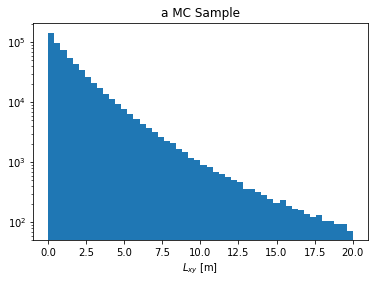

In [114]:
plt.hist(lxy.flatten(), bins=50, range=(0,20))
plt.yscale('log')
plt.xlabel('$L_{xy}$ [m]')
_ = plt.title('a MC Sample')

# Some info about the old analyses

1. [CalRatio Internal Note](https://cds.cern.ch/record/2268150)
1. [MSID Internal Note](https://cds.cern.ch/record/2256102)

The general plots for reconstruction efficiency can be seen here. CalRatio is trigger only on the right, and MS reconstruction on the left:

![](CalRatio-Trigger-Eff-Lxy.png)![](MS-Reco-Eff_lxy.png)

It would seem reasonable to use 30% efficency for both, 2.0m-3.5m for the CalRatio, and 4.0m-7.0m for the MS.

In [91]:
from typing import Tuple
class detector_range:
    def __init__(self, name: str, range: Tuple[float, float], eff: float):
        self._name = name
        self._x_min = range[0]
        self._x_max = range[1]
        self._eff = eff
        
    def draw_lxy_box(self):
        x_center = (self._x_max - self._x_min)/2 + self._x_min

        axes = plt.gca()
        y_min = axes.get_ylim()[0]
        y_max = axes.get_ylim()[1] * 0.90
        y_center = (y_max - y_min)/2 + y_min

        plt.text(x_center, y_center, self._name, size=10, ha="center", va="center", color='w')

        r = patches.Rectangle((self._x_min, y_min),self._x_max - self._x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
        plt.gca().add_patch(r)
        axes.add_patch(r)
        
    def mask(self, lxy):
        'Return a max of lxy if lxy is in the range'
        return (lxy > self._x_min) & (lxy <= self._x_max)
        
cal = detector_range('cal', (2.0, 3.5), 0.3)
muon = detector_range('muon', (4.0, 7.0), 0.3)

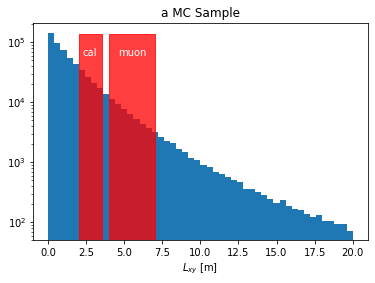

In [115]:
from typing import List
def plot_lxy(lxy, d_info: List[detector_range]):
    plt.hist(lxy.flatten(), bins=50, range=(0,20))
    for d in d_info:
        d.draw_lxy_box()
    plt.yscale('log')
    plt.xlabel('$L_{xy}$ [m]')
    _ = plt.title('a MC Sample')
    
plot_lxy(lxy, (cal, muon))

Now, calculate the number of times we have a decay in the cal and the muon

In [116]:
has_muon = muon.mask(lxy)
has_cal = cal.mask(lxy)

In [120]:
def count_with_one(lxy, mask):
    s = lxy[mask].count()
    return len(s[s == 2].flatten())

print (f'cal  = {count_with_one(lxy, has_cal)}')
print (f'muon = {count_with_one(lxy, has_muon)}')

cal  = 7633
muon = 2032


In [121]:
def count_with_two(lxy, mask_1, mask_2):
    s_1 = lxy[mask_1].count()
    s_2 = lxy[mask_2].count()
    
    r = s_1[(s_1 == 1) & (s_2 ==1 )]
    return len(r.flatten())

count_with_two(lxy, has_muon, has_cal)

7763

In [123]:
def count_events_in_detector(lxy, mask):
    s = lxy[mask].count()
    return len(s[s > 0].flatten())

print (f'Events with Cal  = {count_events_in_detector(lxy, has_cal)}')
print (f'Events with Muon = {count_events_in_detector(lxy, has_muon)}')

Events with Cal  = 87548
Events with Muon = 47853


In [131]:
info = dict(evt_total = len(lxy),
            evt_cal=count_events_in_detector(lxy, has_cal),
            evt_muon=count_events_in_detector(lxy, has_muon),
            evt_2cal=count_with_one(lxy, has_cal),
            evt_2muon=count_with_one(lxy, has_muon),
            evt_cal_muon=count_with_two(lxy, has_muon, has_cal)
           )

In [133]:
pd.DataFrame(list(info.items())).T

,0,1,2,3,4,5
0,evt_total,evt_cal,evt_muon,evt_2cal,evt_2muon,evt_cal_muon
1,300000,87548,47853,7633,2032,7763
